# Analysis part - Blastoise___Holo_1999_Base_Set

In [11]:
library(ggplot2)
library(quantreg)


df = read.csv('merged_datasets_final/merged_Blastoise___Holo_1999_Base_Set.csv')

#convert prices to returns
grades <- grep("grade[0-9]+price", names(df), value = TRUE)
grade_returns <- sapply(grades, function(x) paste0(x, "_return"))

for(grade in grades) {
  df[paste(grade, "return", sep = "_")] <- c(NA, diff(log(df[[grade]])))
}

#convert adjclosestock to returns
df$adjclosestock_return <- c(NA, diff(log(df$adjclosestock)))

#remove rows with NA in the newly created return columns
df <- na.omit(df)

head(df)

,date,grade5price,grade6price,grade7price,grade8price,grade9price,grade10price,adjclosestock,volume,adjclosebond,stockreturns,bondadjusted,excessreturns,grade5price_return,grade6price_return,grade7price_return,grade8price_return,grade9price_return,grade10price_return,adjclosestock_return
2,2016-10-01,10,18.25,25.0,48.95125,76.0000,222.5,2126.15,72915530000,2.589,-0.0194256789,0.02589,-0.127730484,0,0.0000000,0.0000000,0.06207482,-0.2518163,0.0000000,-0.0196168370
3,2016-11-01,10,18.25,25.0,29.51750,76.0000,222.5,2198.81,88445380000,3.017,0.0341745218,0.03017,-0.131140262,0,0.0000000,0.0000000,-0.50584160,0.0000000,0.0000000,0.0336035450
4,2016-12-01,10,24.99,25.0,26.72000,39.6200,222.5,2238.83,75344550000,3.063,0.0182007624,0.03063,0.002953827,0,0.3143107,0.0000000,-0.09957096,-0.6513993,0.0000000,0.0180371113
5,2017-01-01,10,24.99,20.5,31.00000,78.4175,192.5,2278.87,70576420000,3.051,0.0178843582,0.03051,0.021802036,0,0.0000000,-0.1984509,0.14857486,0.6827131,-0.1448309,0.0177263146
6,2017-02-01,10,24.99,20.5,23.25000,55.9920,151.0,2363.64,69260940000,2.968,0.0371981601,0.02968,0.064402414,0,0.0000000,0.0000000,-0.28768207,-0.3368383,-0.2428163,0.0365230007
7,2017-03-01,10,24.99,20.5,24.50000,76.5120,151.0,2362.72,81664010000,3.018,-0.0003891971,0.03018,-0.017235543,0,0.0000000,0.0000000,0.05236799,0.3122388,0.0000000,-0.0003892729


## Visualisation

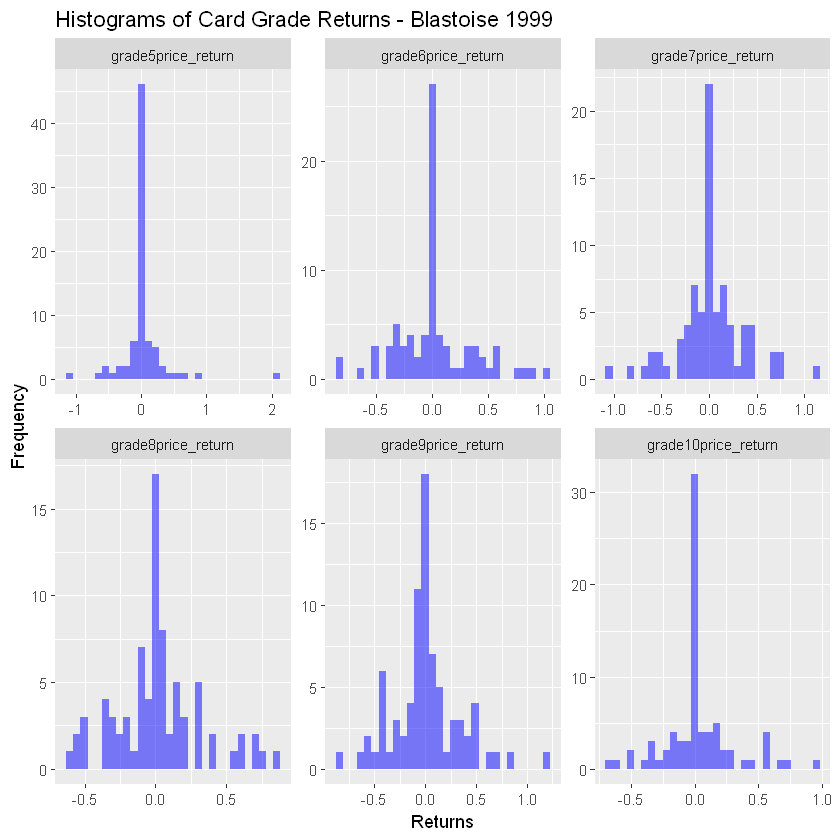

In [12]:

#create a long format data frame suitable for faceting with returns
long_df <- reshape2::melt(df, id.vars = "date", measure.vars = grade_returns)

#histograms for card grade returns
p1 <- ggplot(long_df, aes(x = value)) +
  geom_histogram(bins = 30, fill = "blue", alpha = 0.5) +
  facet_wrap(~ variable, scales = "free") +
  labs(x = "Returns", y = "Frequency", title = "Histograms of Card Grade Returns - Blastoise 1999")

print(p1)

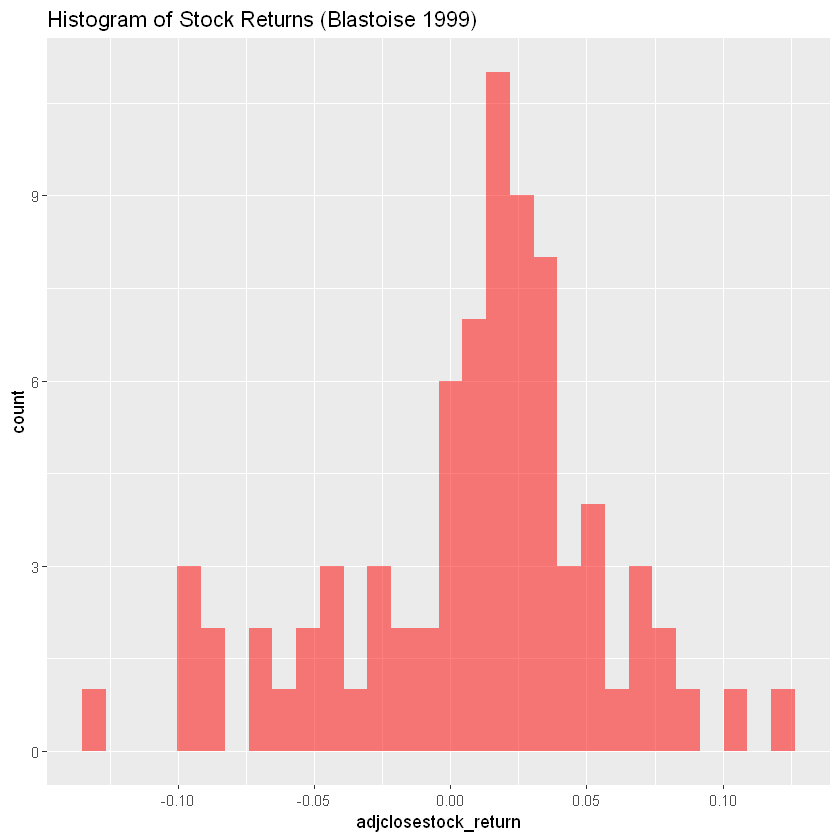

In [13]:
#histogram of stock returns
p2 <- ggplot(df, aes(x = adjclosestock_return)) +
  geom_histogram(bins = 30, fill = "red", alpha = 0.5) +
  labs(title = "Histogram of Stock Returns (Blastoise 1999)")

print(p2)

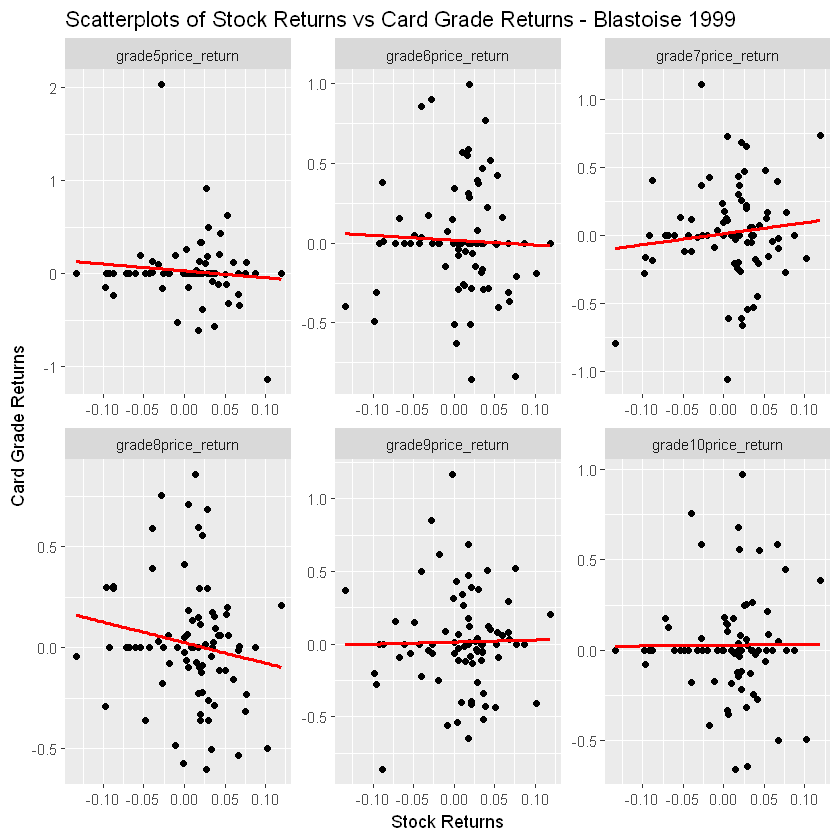

In [14]:
#a long format data frame suitable for scatterplots with returns
long_df <- reshape2::melt(df, id.vars = c("date", "adjclosestock_return"), measure.vars = grade_returns)

#scatterplots between stock returns and card grades returns
p3 <- ggplot(long_df, aes(x = adjclosestock_return, y = value)) +
  geom_point() +
  geom_smooth(method = "lm", se = FALSE, color = "red") +
  facet_wrap(~ variable, scales = "free") +
  labs(x = "Stock Returns", y = "Card Grade Returns", title = "Scatterplots of Stock Returns vs Card Grade Returns - Blastoise 1999")

print(p3)

## Models

### OLS

In [15]:
#OLS
ols_models <- list()
for(grade_return in grade_returns) {
  ols_models[[grade_return]] <- lm(get(grade_return) ~ adjclosestock_return, data = df)
}

#print summary of each OLS model
for(grade_return in grade_returns) {
  print(paste("Summary of model for:", grade_return))
  print(summary(ols_models[[grade_return]]))
}


[1] "Summary of model for: grade5price_return"

Call:
lm(formula = get(grade_return) ~ adjclosestock_return, data = df)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.09358 -0.08032 -0.01615  0.03136  1.98294 

Coefficients:
                     Estimate Std. Error t value Pr(>|t|)
(Intercept)           0.02871    0.03914   0.734    0.465
adjclosestock_return -0.73738    0.80442  -0.917    0.362

Residual standard error: 0.3428 on 77 degrees of freedom
Multiple R-squared:  0.01079,	Adjusted R-squared:  -0.002052 
F-statistic: 0.8403 on 1 and 77 DF,  p-value: 0.3622

[1] "Summary of model for: grade6price_return"

Call:
lm(formula = get(grade_return) ~ adjclosestock_return, data = df)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.86742 -0.17586 -0.01524  0.12273  0.98173 

Coefficients:
                     Estimate Std. Error t value Pr(>|t|)
(Intercept)           0.01837    0.04014   0.458    0.648
adjclosestock_return -0.30175    0.82494  -0.366    0.716


### Quantile regression

In [16]:
#Quantile regression
library(quantreg)

quantile_models <- list()
for(grade_return in grade_returns) {
  quantile_models[[grade_return]] <- rq(get(grade_return) ~ adjclosestock_return, data = df, tau = 0.1)  #change tau for different quantiles
}

#print summary of quantile regression models
for(grade_return in grade_returns) {
  print(paste("Summary of quantile regression model for:", grade_return))
  print(summary(quantile_models[[grade_return]]))
}


[1] "Summary of quantile regression model for: grade5price_return"

Call: rq(formula = get(grade_return) ~ adjclosestock_return, tau = 0.1, 
    data = df)

tau: [1] 0.1

Coefficients:
                     coefficients lower bd upper bd
(Intercept)          -0.26403     -0.47397 -0.14317
adjclosestock_return -1.14293     -2.28933 -0.29288
[1] "Summary of quantile regression model for: grade6price_return"

Call: rq(formula = get(grade_return) ~ adjclosestock_return, tau = 0.1, 
    data = df)

tau: [1] 0.1

Coefficients:
                     coefficients lower bd upper bd
(Intercept)          -0.37426     -0.51089 -0.29414
adjclosestock_return  0.15785     -0.43363  1.02351
[1] "Summary of quantile regression model for: grade7price_return"

Call: rq(formula = get(grade_return) ~ adjclosestock_return, tau = 0.1, 
    data = df)

tau: [1] 0.1

Coefficients:
                     coefficients lower bd upper bd
(Intercept)          -0.46149     -0.62710 -0.22856
adjclosestock_return  2.47718

In [17]:
#Quantile regression
library(quantreg)

quantile_models <- list()
for(grade_return in grade_returns) {
  quantile_models[[grade_return]] <- rq(get(grade_return) ~ adjclosestock_return, data = df, tau = seq(from=0.05, to=0.95, by=0.05))  #change tau for different quantiles
}

#print summary of quantile regression models
for(grade_return in grade_returns) {
  #print(paste("Summary of quantile regression model for:", grade_return))
  #print(summary(quantile_models[[grade_return]]))
}

#uncomment the last two commented rows (in the previous loop) if you want to see the results for quantiles from 0.05 to 0.95, by 0.05 step

#### Results for different quantiles of the grade prices x OLS estimates (red line) 

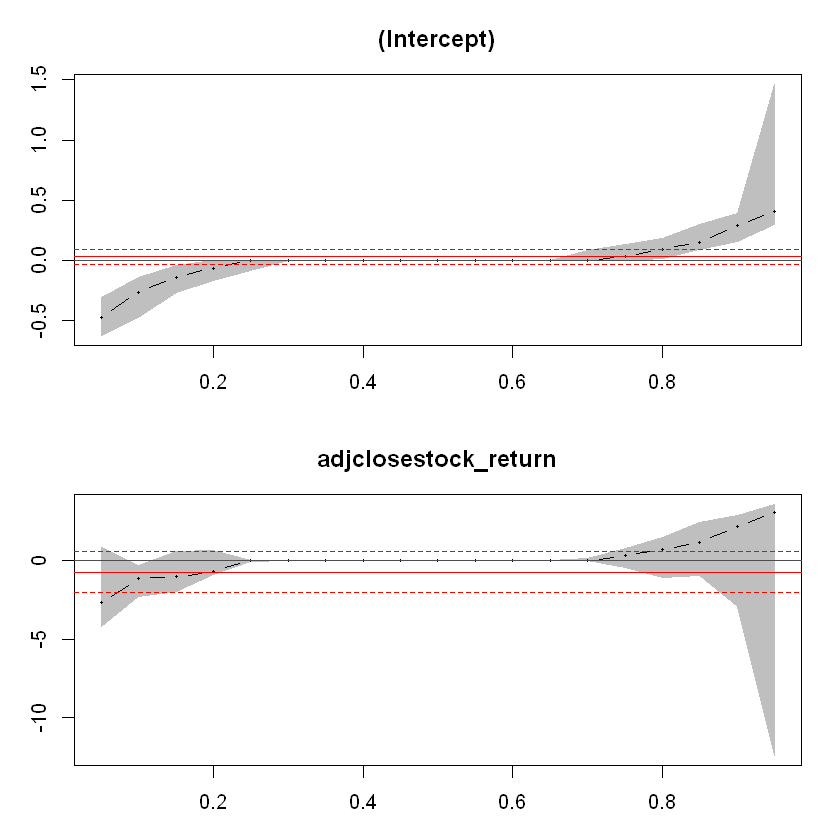

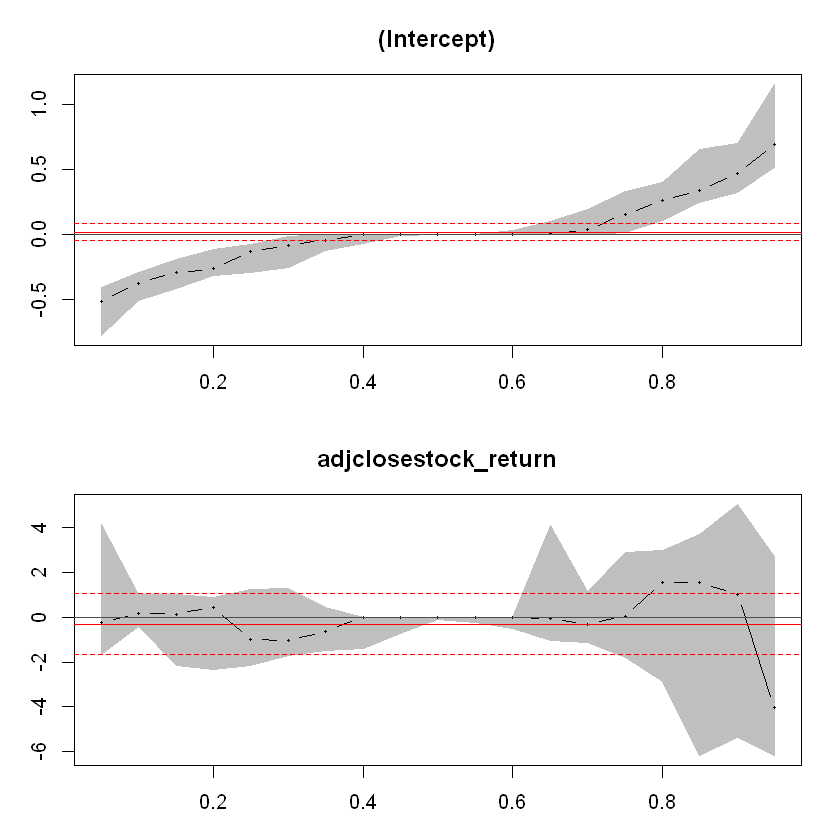

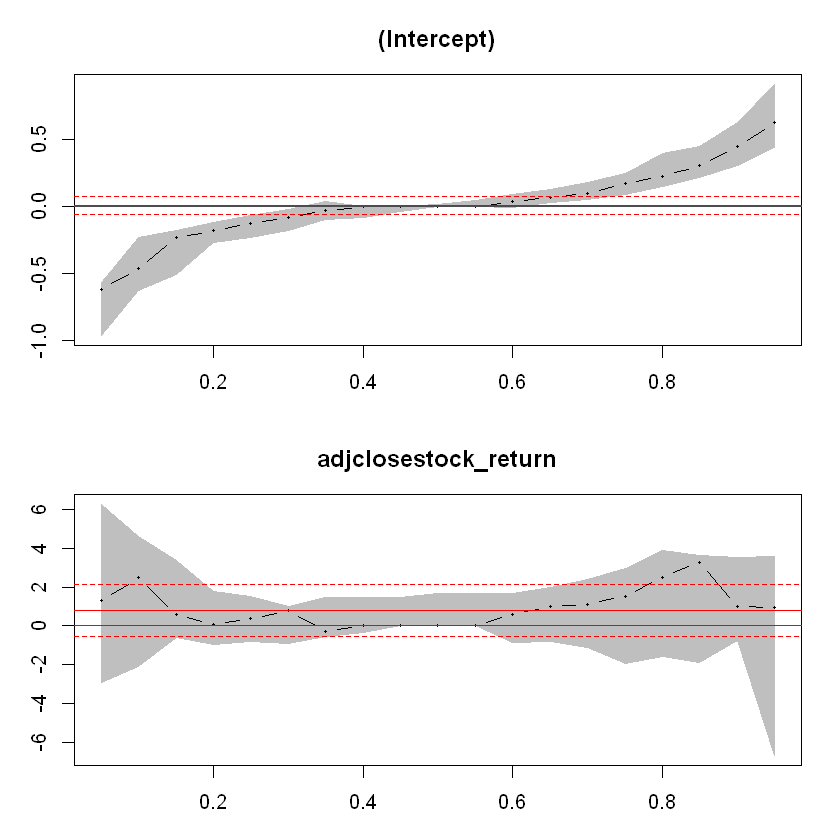

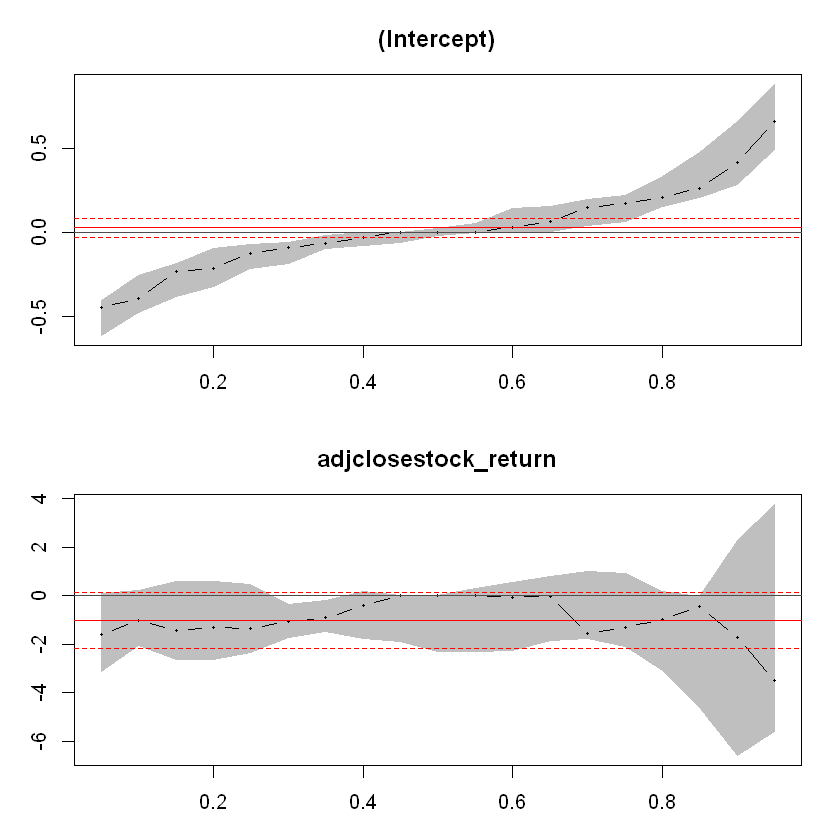

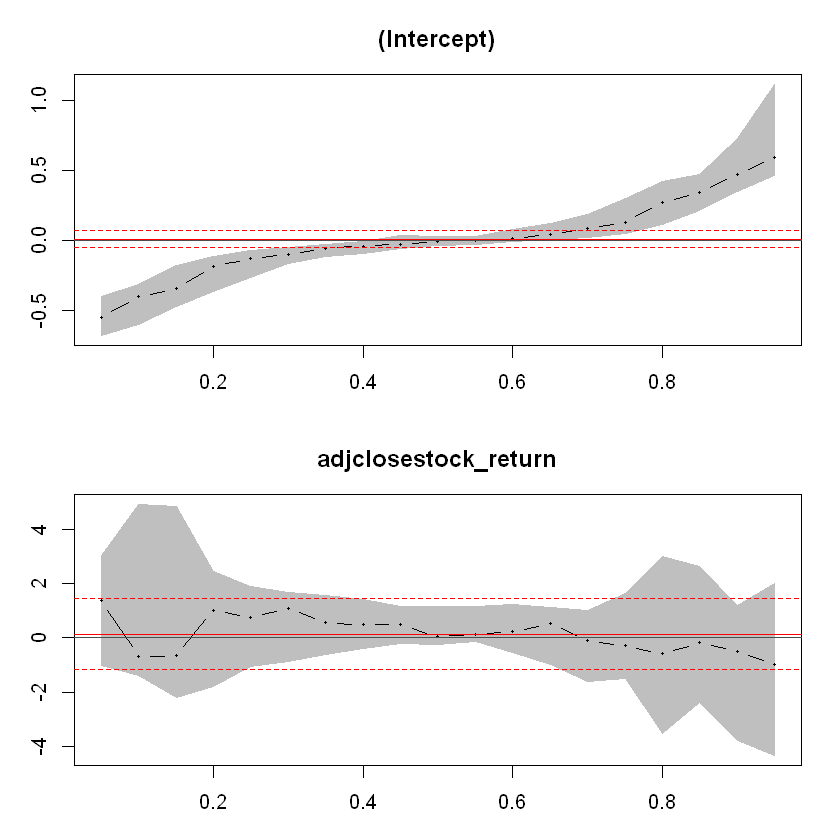

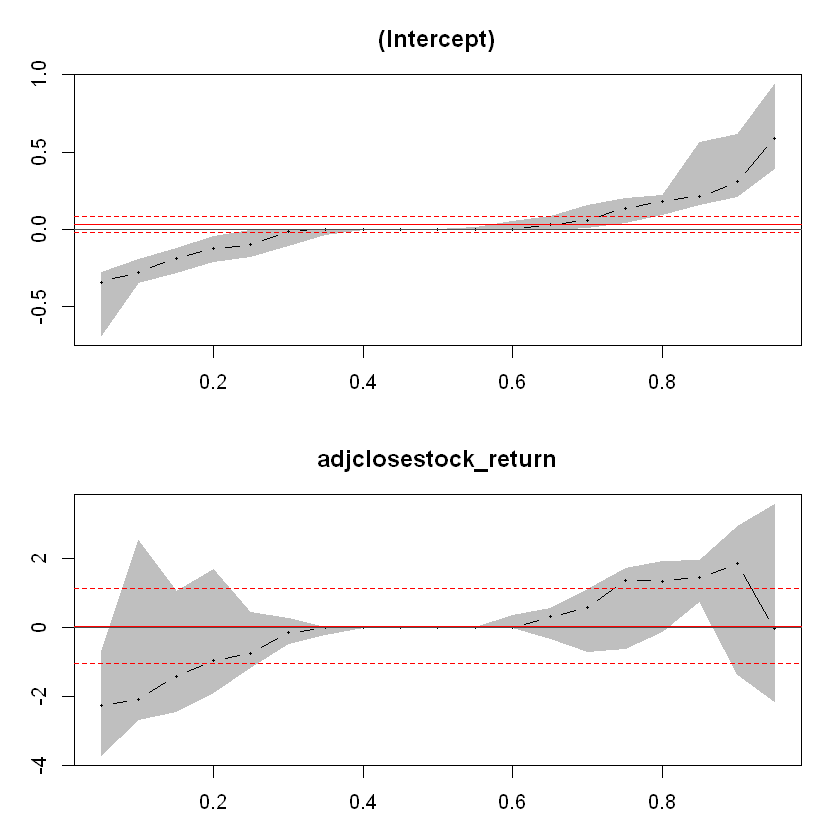

In [18]:

for(grade_return in grade_returns) {
  #print(paste("Summary of quantile regression model for:", grade_return))
  #print(summary(quantile_models[[grade_return]]))
  plot(summary(quantile_models[[grade_return]]))
}